# Adding trends
*R.A. Collenteur (University of Graz), O.N. Ebbens (Artesia)*

In this notebook it is explained how to use linear and step trend models to improve the simulation of groundwater levels.

In [10]:
import pandas as pd

import pastas as ps

ps.set_log_level("INFO")
ps.show_versions()

Pastas version: 1.12.0b
Python version: 3.13.7
NumPy version: 2.3.4
Pandas version: 2.3.3
SciPy version: 1.16.3
Matplotlib version: 3.10.7
Numba version: 0.62.1


## 1. Modeling a linear trend
In this first example we look at a model where a linear trend is used to improve the simulation of the groundwater levels. The linear trend is modeled using the `LinearTrend` stress model. We start with a model where we try to explain the groundwater level fluctuations using precipitation and evaporation. A simple non-linear recharge model is used to translate these fluxes into recharge and finally groundwater levels.

The Time Series 'B32C0609_1' has nan-values. Pastas will use the fill_nan settings to fill up the nan-values.
The Time Series 'RH_260' has nan-values. Pastas will use the fill_nan settings to fill up the nan-values.


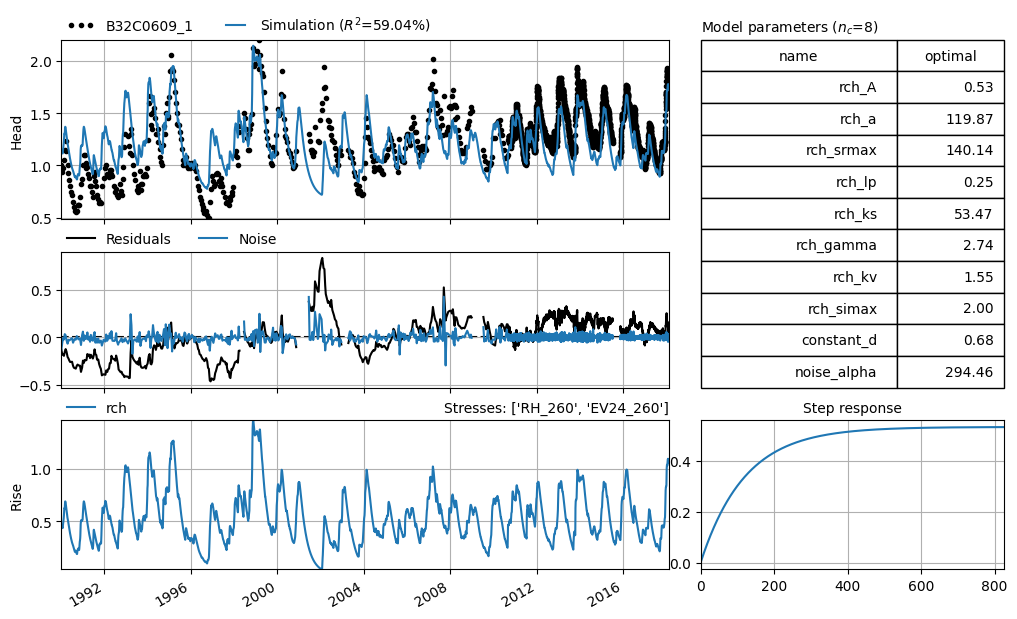

In [ ]:
# Load the input data
evap = pd.read_csv("data/evap_260.csv", index_col=0, parse_dates=[0]).squeeze()
rain = pd.read_csv("data/rain_260.csv", index_col=0, parse_dates=[0]).squeeze()
head = pd.read_csv("data/B32C0609001.csv", index_col=0, parse_dates=True).squeeze()

# Create a Pastas model
ml = ps.Model(head)
ml.add_noisemodel(ps.ArNoiseModel())

# Add a recharge model
rch = ps.rch.FlexModel()
rm = ps.RechargeModel(rain, evap, recharge=rch, rfunc=ps.Exponential(), name="rch")
ml.add_stressmodel(rm)

# Solve and plot the model
ml.solve(tmin="1990", report=False)  # Get better initial estimated first
ml.add_noisemodel(ps.ArNoiseModel())
ml.solve(tmin="1990", initial=False, report=False)
ml.plots.results(figsize=(10, 6));

### Add linear trend to the model
Clearly the model fit with the data in the above figure is not so good. Looking at the model residuals (simulation - observation) we can observe a steady upward trend in the residuals. Let's try and add a linear trend to the model to improve the groundwater level simulation.

Fit report B32C0609_1                Fit Statistics
nfev     19                     EVP           86.02
nobs     3016                   R2             0.86
noise    True                   RMSE           0.09
tmin     1990-01-01 00:00:00    AICc      -23491.49
tmax     2018-02-14 00:00:00    BIC       -23437.44
freq     D                      Obj            0.62
freq_obs None                   ___                
warmup   3650 days 00:00:00     Interp.          No

Parameters (9 optimized)
                    optimal        initial   vary
rch_A              0.760258       0.707647   True
rch_a            181.534233     160.976877   True
rch_srmax        137.382355     162.356729   True
rch_lp             0.250000       0.250000  False
rch_ks            55.494398      78.512142   True
rch_gamma          2.472138       2.483929   True
rch_kv             1.520372       1.704982   True
rch_simax          2.000000       2.000000  False
trend_a            0.000042       0.000000   True
trend_

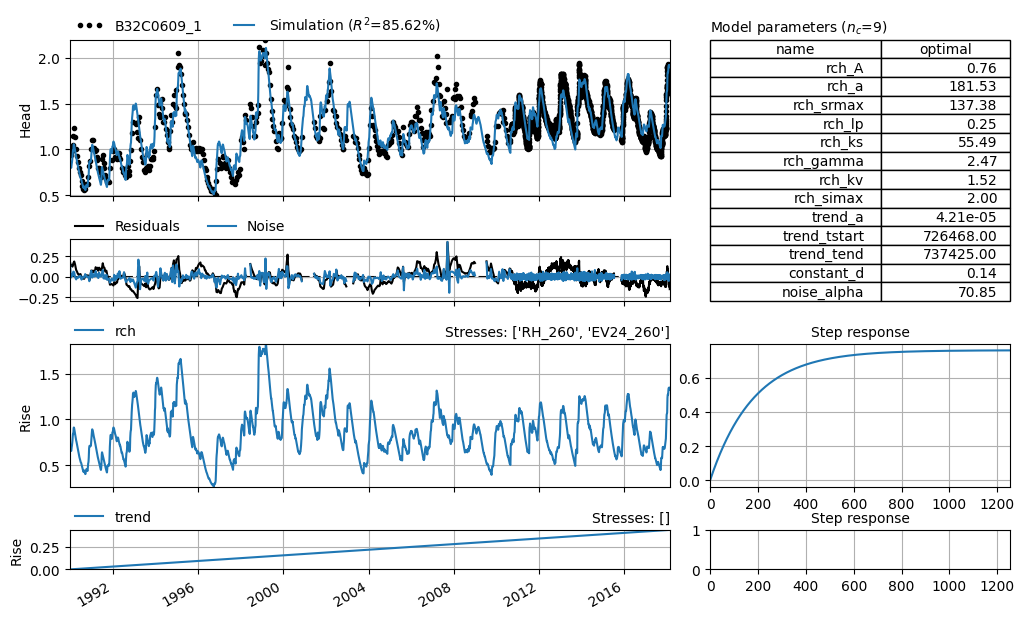

In [3]:
# Add a linear trend
tm = ps.LinearTrend(start="1990-01-01", end="2020-01-01", name="trend")
ml.add_stressmodel(tm)

# Solve the model
ml.solve(tmin="1990", initial=False, report=True)
ml.plots.results(figsize=(10, 6));

## 2. Modeling a step trend
In this example the modeling of step trends in groundwater level time series is explored. Step trends can be used when a system change has taken place during the observation period, for example a lowering of the surrounding water levels. Here we model a groundwater level time series observed near the city of Eindhoven in the Netherlands that has undergone a structural change during the time of observation. The change has taken place in 2012, but unfortunately no observations are available for the period when the change was made.

### model with precipitation and evaporation
First a model with only precipitation and potential evaporation as explanatory variables is created. It can be observed that the peak in the groundwater levels after 2012 lie about 0.5 meters lower that the peaks before 2012. This can also be observed by studying the model residuals, which show a different mean for the period before 2012 and after 2012.

In [ ]:
p = pd.read_csv("data/nb18_rain.csv", index_col=0, parse_dates=True).squeeze()
e = pd.read_csv("data/nb18_evap.csv", index_col=0, parse_dates=True).squeeze()
h = pd.read_csv("data/nb18_head.csv", index_col=0, parse_dates=True).squeeze()

ml = ps.Model(h)
ml.add_noisemodel(ps.ArNoiseModel())

sm = ps.RechargeModel(
    p, e, name="recharge", rfunc=ps.Exponential(), recharge=ps.rch.Linear()
)
ml.add_stressmodel(sm)
ml.solve(report=False, freq_obs="10D")

ml.plots.results(figsize=(10, 5));

### Adding a step trend
Clearly, the model creating above has room for improvements. Since we know a system change has taken place around 2012, we can try and simulate this system change by adding a step trend. We do not know the absolute size of this step trend, only the time when it has taken place (1st of July 2012). The `StepModel` is available in Pastas to add a step trend to a model. This stress model does not require a independent time series, but a(indication of) the date of the system change instead. By default the `StepModel` applies an instantaneous step in the groundwater level, using the `One` response function. it is however also possible to choose a more gradual change by applying another type of response function.

In [ ]:
step = ps.StepModel(tstart=pd.Timestamp("2012-07-01"), name="step", up=None)
ml.add_stressmodel(step)
ml.solve(report=False)

ml.plots.results(figsize=(10, 5));

## Diagnostic checking
In the following, the uncertainty of the estimated step trend is evaluated. Before we quantify the uncertainty, we perform some model diagnostic checks on the noise time series using `ps.plots.diagnostics()`. From this plot, we can say that the noise looks normally distributed and has no significant autocorrelation. Thus we may use the standard errors of the estimated parameters to quantify the uncertainty of the estimated step trend.

In [ ]:
ml.plots.diagnostics(figsize=(10, 4));

## 3. Uncertainty of step trend
Below we draw the 95% confidence interval of the step trend. We may use this confidence interval to interpret the results. For example, if we know or expect that the step trend is negative, we can reject the step trend from the model if the confidence interval also includes positive step trends. In this example this is not the case and the estimated step trend is always negative as expected.

In [ ]:
ci = ml.solver.ci_contribution("step", alpha=0.05)
axes = ml.plots.results(adjust_height=False, figsize=(10, 5))
axes[-2].fill_between(ci.index, ci.iloc[:, 0], ci.iloc[:, 1], zorder=-10, alpha=0.5);

## 4. Effect of system changes
Sometimes changes to a groundwater system cannot be easily modelled using a step trend. For example when the system change causes a different response of the groundwater to recharge. In that case there are other methods to visualise the effect of the system change on the groundwater head. Two of these methods are shown below:

1. Fit the model on the observations before the system change. Use this model to simulate the groundwater head after the system change. The differences between simulated groundwater heads an observations are an indication of the effect of the system change on the groundwater head.
2. similar to method 1. Now the model is fit on the period **after** the system change and groundwater heads are simulated for the period **before** the system change. 

In [ ]:
# method 1
ml_before = ps.Model(h[:"2012-07-01"])
ml_before.add_noisemodel(ps.ArNoiseModel())

sm = ps.RechargeModel(
    p, e, name="recharge", rfunc=ps.Exponential(), recharge=ps.rch.Linear()
)
ml_before.add_stressmodel(sm)
ml_before.solve(report=False, freq_obs="10D")

ax = h.iloc[::10].plot(marker=".", color="k", ls="none", label="head", figsize=(10, 3))
ml_before.simulate().plot(ax=ax, label="model fit")
ml_before.simulate(tmin="2012-07-01", tmax=h.iloc[::10].index[-1]).plot(
    ax=ax, label="simulation"
)

ax.legend(ncol=3)
ax.grid()

In [ ]:
# method 2
ml_after = ps.Model(h.loc[pd.Timestamp("2012-07-01") :])
ml_after.add_noisemodel(ps.ArNoiseModel())

sm = ps.RechargeModel(
    p, e, name="recharge", rfunc=ps.Exponential(), recharge=ps.rch.Linear()
)
ml_after.add_stressmodel(sm)
ml_after.solve(report=False, freq_obs="10D")


ax = h.iloc[::10].plot(marker=".", color="k", ls="none", label="head", figsize=(10, 3))
ml_after.simulate().plot(ax=ax, label="model fit")
ml_after.simulate(tmin=h.iloc[::10].index[0], tmax=pd.Timestamp("2012-07-01")).plot(
    ax=ax, label="simulation"
)

ax.legend(ncol=3)
ax.grid()

<div class="alert alert-block alert-info admonition-tip">
<b>Tip:</b> In principle it is possible to estimate the date of the change by varying the `step_tstart` parameter. In practice however estimating such a date is rather difficult and not recommended.   
</div>  

## References
- Precipitation time series are taken from the KNMI weather station in Helmond
- Potential evaporation time series are taken from KNMI meteorological station in Eindhoven
- The groundwater level time series are taken from Dinoloket (B51G2150, Filter 1)